<a href="https://colab.research.google.com/github/FrodoBaggins87/Machine_Learning/blob/main/Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Generate Toy Dataset


In [42]:
import sklearn
from sklearn.datasets import make_circles

#choose number of samples
n_samples=1000

#create circles
x,y=make_circles(n_samples,
                 noise=0.02,
                 random_state=66)

In [43]:
len(x), len(y)

(1000, 1000)

In [44]:
print(x[:5])
print(y[:5])

[[-0.72974363  0.68637738]
 [ 0.66264716 -0.44070676]
 [-0.25925316  0.77418256]
 [-0.48943149 -0.61886408]
 [ 0.08215533  1.04318507]]
[0 1 1 1 0]


In [45]:
import pandas as pd
circle_data=pd.DataFrame({"x_1":x[:,0],
                         "x_2":x[:,1],
                         "label":y})
circle_data.head()

,x_1,x_2,label
0,-0.729744,0.686377,0
1,0.662647,-0.440707,1
2,-0.259253,0.774183,1
3,-0.489431,-0.618864,1
4,0.082155,1.043185,0


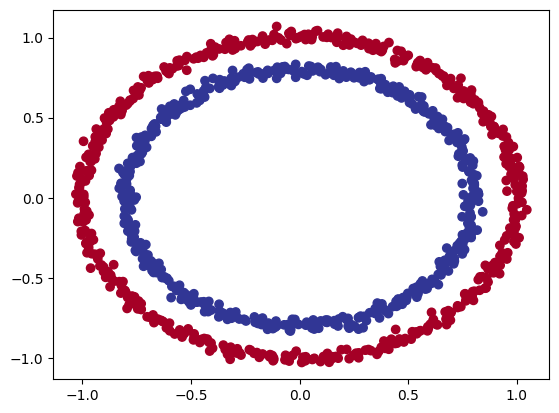

In [46]:
#Visulaizing data
import matplotlib.pyplot as plt
plt.scatter(x=x[:,0],
            y=x[:,1],
            c=y, #colour deided by the value in y
            cmap=plt.cm.RdYlBu)#cmap sets the color map based on value of y

Check input and output shapes


In [47]:
x.shape,y.shape

((1000, 2), (1000,))

In [48]:
print("sample x value", x[0])
print("sample y value", y[0])

sample x value [-0.72974363  0.68637738]
sample y value 0


Turn data into tensors


In [49]:
import torch
torch.__version__

'2.1.0+cu121'

In [50]:
type(x)

numpy.ndarray

In [51]:
#Turn into tensor
x_tensor=torch.from_numpy(x).type(torch.float)
y_tensor=torch.from_numpy(y).type(torch.float)#float will convert to float32 by default
type(x_tensor),type(y_tensor),x_tensor.dtype,y_tensor.dtype

(torch.Tensor, torch.Tensor, torch.float32, torch.float32)

In [52]:
#split into training and test dataset
from sklearn.model_selection import train_test_split

x_train,x_test,y_train,y_test= train_test_split(x_tensor,
                                                y_tensor,
                                                test_size=0.2) #20% of whole dataset)

In [53]:
len(x_train),len(x_test),len(y_train),len(y_test)

(800, 200, 800, 200)

Building a model


In [54]:
import torch
from torch import nn
#make device agnostic code
device= "cuda" if torch.cuda.is_available() else "cpu"
device

'cpu'

Now, the following steps will be done:
1. Make a subclass of nn.Module
2. Create 2 nn.Linear layers that are capable of handling shapes of our data
3. Define a forward() method based on forward computation required
4. Make an instance of the subclass and send to target device

In [55]:
x_train.shape, y_train.shape #small side note: shape here is not a method but an attribute of ndarray thats why no ()

(torch.Size([800, 2]), torch.Size([800]))

In [56]:
class Circle_Model(nn.Module):
  def __init__(self):
    super().__init__()
    #in_features and out_features selected based on shape of x_train and y_train
    self.layer_1=nn.Linear(in_features=2, out_features=5)#takes 2 features (the coordinates) and gives out a specific number of features chosen by out_features parameter
    self.layer_2=nn.Linear(in_features=5, out_features=1)#takes features produced by first layer and gives 1 feature

    #define forward pass
    def forward(self,x):
      return self.layer_2(self.layer_1(x)) #x goes through first layer then second layer then gives output

#make an instance of our model
model_0=Circle_Model().to(device)
model_0

Circle_Model(
  (layer_1): Linear(in_features=2, out_features=5, bias=True)
  (layer_2): Linear(in_features=5, out_features=1, bias=True)
)

In [57]:
device

'cpu'

In [58]:
(next(model_0.parameters())).device# parameters() method in nn.Module returns an iterable over the parameters of the model, next() function is used to iterate once over the  iterable, hence reaching its fist value which is returned, .device is an attribute of nn.Module returning the device which the accessed parameter is stored in

device(type='cpu')

In [59]:
type(model_0.parameters())

generator

In [60]:
#replicating the model using nn.Sequential

model_0=nn.Sequential(
    nn.Linear(in_features=2, out_features=5),
    nn.Linear(in_features=5, out_features=1)
).to(device)

model_0# figure out how to change dtype of weights of a model

#makes essentially the same neural network as was made above as subclass of nn.Module
#using this will make all the required layers of the network at once while defining attributes of subclass in nn.Module insteead of defining each individually
#use this when network to be made is simple, if network is very customized use code like above making subclasses

Sequential(
  (0): Linear(in_features=2, out_features=5, bias=True)
  (1): Linear(in_features=5, out_features=1, bias=True)
)

In [61]:
#make untrained predictions
with torch.inference_mode():
  untrained_pred=model_0(x_test)
print("shape of untrained predictions:", untrained_pred.shape)
print("shape of test sample", x_test.shape)
print("first 10 predictions", torch.round(untrained_pred[:10]))
print("first 10 y_test", y_test[:10])


shape of untrained predictions: torch.Size([200, 1])
shape of test sample torch.Size([200, 2])
first 10 predictions tensor([[0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.]])
first 10 y_test tensor([0., 1., 0., 0., 1., 1., 0., 1., 1., 0.])


Setting up Loss Function and Optimizer:
Which ones to use?
1. For Regression: MAE or MSE is generally used.
2. For Classificaiton: Binary Cross Entropy or Categorical Cross Entropy is used generally
3. Optimizer: Most useful ones are SGD and Adam

In [62]:
#here will use BCE with Sigmoid function built in
loss_fn=nn.BCEWithLogitsLoss()# read its documentaiton
optimizer=torch.optim.SGD(params=model_0.parameters(),
                          lr=0.1)

In [63]:
#calculate accuracy
def accuracy_calc(y_true, y_pred):
  correct=torch.eq(y_true,y_pred).sum().item()#eq function makes a boolean tensor with True wherever both values are equal, sum() method adds up all elements and returns a tensor, item() method returns the numerical value of the values in tensor
  acc=(correct/len(y_pred))*100# in percentage
  return acc

Train Model:
1. Forward Pass
2. Calculate Loss
3. Set Optimizer Zero Grad
4. BackPropogation
5. Gradient Descent


In [64]:
model_0.eval() #putting in evaluation mode
#havent started the training loop yet still manually seeing how training will go
with torch.inference_mode():
  y_logits=model_0(x_test)
print(y_logits[:5])
len(y_logits)

tensor([[0.0945],
        [0.0584],
        [0.2740],
        [0.2902],
        [0.3560]])


200

In [65]:
y_test[:5]

tensor([0., 1., 0., 0., 1.])

In [66]:
y_pred_probs=torch.sigmoid(y_logits)# using sigmoid activation function
print(y_pred_probs[:5])
len(y_pred_probs)

tensor([[0.5236],
        [0.5146],
        [0.5681],
        [0.5721],
        [0.5881]])


200

In [67]:
#Calculating prediction 2 diff ways
y_preds=torch.round(y_pred_probs)
# now in full
y_preds_again= torch.round(torch.sigmoid(model_0(x_test)))
#checking for equality
print(torch.eq(y_preds.squeeze(),y_preds_again.squeeze()))
#getting rid of extra dimension in prediction
y_preds.squeeze()

tensor([True, True, True, True, True, True, True, True, True, True, True, True,
        True, True, True, True, True, True, True, True, True, True, True, True,
        True, True, True, True, True, True, True, True, True, True, True, True,
        True, True, True, True, True, True, True, True, True, True, True, True,
        True, True, True, True, True, True, True, True, True, True, True, True,
        True, True, True, True, True, True, True, True, True, True, True, True,
        True, True, True, True, True, True, True, True, True, True, True, True,
        True, True, True, True, True, True, True, True, True, True, True, True,
        True, True, True, True, True, True, True, True, True, True, True, True,
        True, True, True, True, True, True, True, True, True, True, True, True,
        True, True, True, True, True, True, True, True, True, True, True, True,
        True, True, True, True, True, True, True, True, True, True, True, True,
        True, True, True, True, True, Tr

tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 1., 1., 1., 1., 1.,
        0., 1., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 0., 1., 1., 1., 0., 1., 1., 0., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 1., 1., 1., 1., 1., 1.,
        1., 1.])

In [68]:
#making training loop
torch.manual_seed(40)
torch.cuda.manual_seed(40)

#set number of epochs
epochs=100

#put data to target device
x_train, y_train= x_train.to(device), y_train.to(device)
x_test, y_test= x_test.to(device),y_test.to(device)

#starting loop
for epoch in range(epochs):
  #Training
  model_0.train()

  #1. Forward Pass
  y_logits=model_0(x_train).squeeze()
  y_pred=torch.round(torch.sigmoid(y_logits))

  #2. Calculate Loss
  #loss_fn is calculated from the values coming from activation function without rounding off, calculating after rounding off wouldnt make sense because after a point it would become 0 and training would stop there and the model wont be as accurate
  loss= loss_fn(y_logits,#here loss_fn function is used which uses BCEWithLogitsLoss, as it has sigmoid function built in it requires raw logits
                y_train)
  #loss= loss_fn(torch.sigmoid(y_logits), #if loss_fn is defined using nn.BCELoss instead of the way it is defined above, then raw logits need to be converted to prediction probabilities to put in BCELoss function
  #              y_train)
  acc=accuracy_calc(y_true=y_train,
                  y_pred=y_pred)
  #3. optimizer zero grad
  optimizer.zero_grad()

  #4. loss backward (backpropogation)
  loss.backward()

  #5. optimizer step (gradient descent)
  optimizer.step()

  #Testing
  model_0.eval()
  with torch.inference_mode():
    # 1. Forward Pass
    test_logits=model_0(x_test).squeeze()
    test_pred=torch.round(torch.sigmoid(test_logits))

    #2. Calculating loss
    test_loss= loss_fn(test_logits,
                       y_test)
    test_acc=accuracy_calc(y_true=y_test,
                           y_pred=test_pred)
  if epoch%10==0:
    print("Epoch:", epoch, "Training Loss:", loss.item(), "Training Accuracy:", acc, "Test Loss:", test_loss.item(), "Test Accuracy:", test_acc)


Epoch: 0 Training Loss: 0.7056468725204468 Training Accuracy: 52.87500000000001 Test Loss: 0.6810441613197327 Test Accuracy: 64.5
Epoch: 10 Training Loss: 0.6981043815612793 Training Accuracy: 50.74999999999999 Test Loss: 0.6869194507598877 Test Accuracy: 56.00000000000001
Epoch: 20 Training Loss: 0.6954883337020874 Training Accuracy: 50.24999999999999 Test Loss: 0.6917076110839844 Test Accuracy: 51.0
Epoch: 30 Training Loss: 0.694476306438446 Training Accuracy: 49.375 Test Loss: 0.6948984265327454 Test Accuracy: 48.0
Epoch: 40 Training Loss: 0.6940049529075623 Training Accuracy: 48.875 Test Loss: 0.6968741416931152 Test Accuracy: 46.0
Epoch: 50 Training Loss: 0.6937298774719238 Training Accuracy: 48.375 Test Loss: 0.6980632543563843 Test Accuracy: 46.0
Epoch: 60 Training Loss: 0.6935365200042725 Training Accuracy: 48.0 Test Loss: 0.6987758874893188 Test Accuracy: 45.0
Epoch: 70 Training Loss: 0.6933847665786743 Training Accuracy: 47.375 Test Loss: 0.6992076635360718 Test Accuracy: 46.

In [69]:
#as can be seen accuracy remains very close to 50% so something seems wrong
#lets check using helper functions
#read what this helper function does from the link

In [70]:
import requests
from pathlib import Path

# Download helper functions from Learn PyTorch repo (if not already downloaded)
if Path("helper_functions.py").is_file():
  print("helper_functions.py already exists, skipping download")
else:
  print("Downloading helper_functions.py")
  request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/helper_functions.py")
  with open("helper_functions.py", "wb") as f:
    f.write(request.content)

from helper_functions import plot_predictions, plot_decision_boundary

helper_functions.py already exists, skipping download


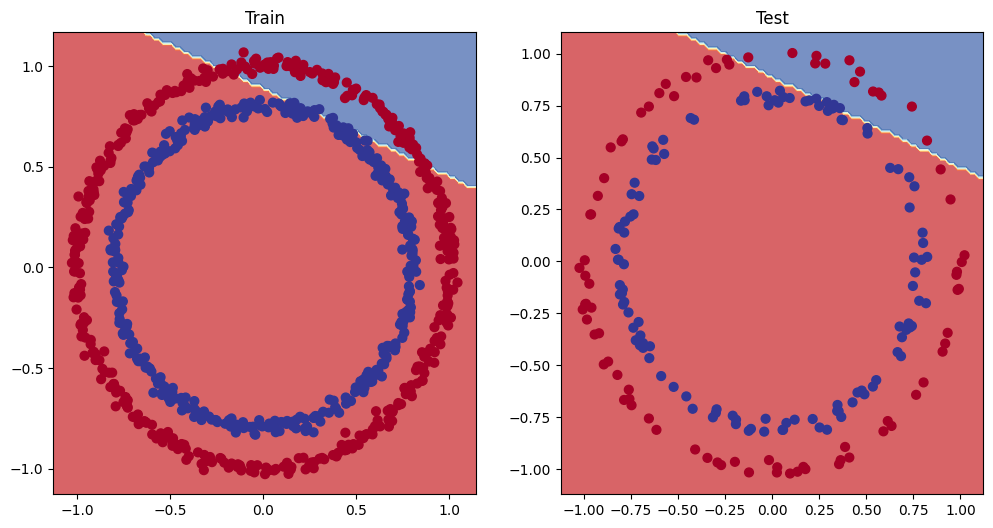

In [71]:
# Plot decision boundaries for training and test sets
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model_0, x_train, y_train)
plt.subplot(1, 2, 2)#why 1,2,2 here?
plt.title("Test")
plot_decision_boundary(model_0, x_test, y_test)

In [72]:
#above graph makes it clear using linear layers is causing the problems as the boundary formed will be linear only

To improve model, following possible things can be done (from the model's perspective not the data perspective):
1. Change number of layers
2. Change number of hidden layer units
3. Change activation function
4. Change learning rate
5. Change the loss function
6. Fit for longer

In [73]:
#making new model with more layers and more features
model_1=nn.Sequential(
    nn.Linear(in_features=2, out_features=10),
    nn.Linear(in_features=10, out_features=10),
    nn.Linear(in_features=10, out_features=1)
).to(device)

model_1

Sequential(
  (0): Linear(in_features=2, out_features=10, bias=True)
  (1): Linear(in_features=10, out_features=10, bias=True)
  (2): Linear(in_features=10, out_features=1, bias=True)
)

In [74]:
#write loss function and optimizer
loss_fn=nn.BCEWithLogitsLoss()# read its documentaiton
optimizer=torch.optim.SGD(params=model_1.parameters(),
                          lr=0.1)

In [75]:

#making training loop
torch.manual_seed(39)
torch.cuda.manual_seed(39)

#set number of epochs
epochs=100

#put data to target device
x_train, y_train= x_train.to(device), y_train.to(device)
x_test, y_test= x_test.to(device),y_test.to(device)

#starting loop
for epoch in range(epochs):
  #Training
  model_1.train()

  #1. Forward Pass
  y_logits=model_1(x_train).squeeze()
  y_pred=torch.round(torch.sigmoid(y_logits))

  #2. Calculate Loss
  #loss_fn is calculated from the values coming from activation function without rounding off, calculating after rounding off wouldnt make sense because after a point it would become 0 and training would stop there and the model wont be as accurate
  loss= loss_fn(y_logits,#here loss_fn function is used which uses BCEWithLogitsLoss, as it has sigmoid function built in it requires raw logits
                y_train)
  #loss= loss_fn(torch.sigmoid(y_logits), #if loss_fn is defined using nn.BCELoss instead of the way it is defined above, then raw logits need to be converted to prediction probabilities to put in BCELoss function
  #              y_train)
  acc=accuracy_calc(y_true=y_train,
                  y_pred=y_pred)
  #3. optimizer zero grad
  optimizer.zero_grad()

  #4. loss backward (backpropogation)
  loss.backward()

  #5. optimizer step (gradient descent)
  optimizer.step()

  #Testing
  model_1.eval()
  with torch.inference_mode():
    # 1. Forward Pass
    test_logits=model_1(x_test).squeeze()
    test_pred=torch.round(torch.sigmoid(test_logits))

    #2. Calculating loss
    test_loss= loss_fn(test_logits,
                       y_test)
    test_acc=accuracy_calc(y_true=y_test,
                           y_pred=test_pred)
  if epoch%20==0:
    print("Epoch:", epoch, "Training Loss:", loss.item(), "Training Accuracy:", acc, "Test Loss:", test_loss.item(), "Test Accuracy:", test_acc)


Epoch: 0 Training Loss: 0.7002802491188049 Training Accuracy: 48.0 Test Loss: 0.6866101026535034 Test Accuracy: 57.99999999999999
Epoch: 20 Training Loss: 0.6928497552871704 Training Accuracy: 49.0 Test Loss: 0.6988982558250427 Test Accuracy: 42.0
Epoch: 40 Training Loss: 0.6925827264785767 Training Accuracy: 43.0 Test Loss: 0.7006264328956604 Test Accuracy: 35.0
Epoch: 60 Training Loss: 0.6924737691879272 Training Accuracy: 52.0 Test Loss: 0.7008294463157654 Test Accuracy: 42.0
Epoch: 80 Training Loss: 0.6924126148223877 Training Accuracy: 52.0 Test Loss: 0.7008601427078247 Test Accuracy: 42.0


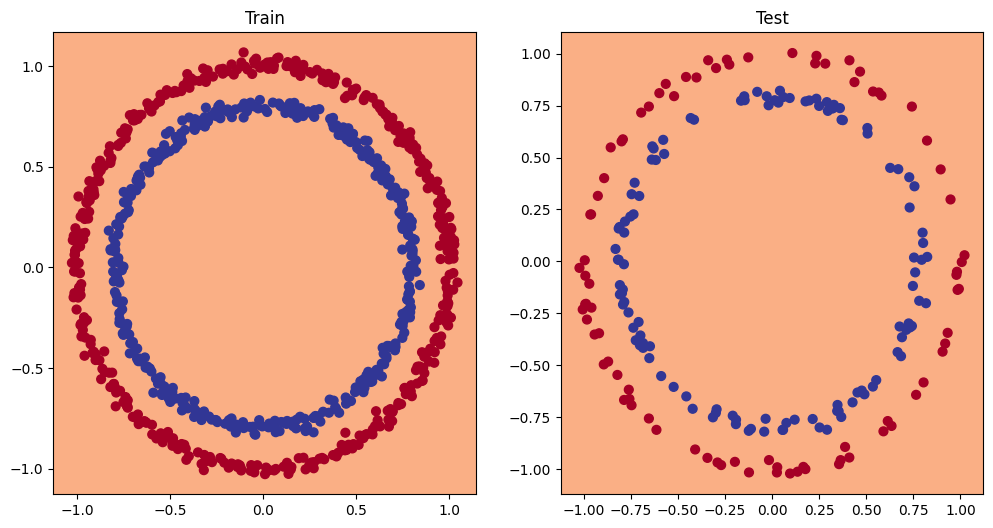

In [76]:
# Plot decision boundaries for training and test sets
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model_1, x_train, y_train)
plt.subplot(1, 2, 2)#why 1,2,2 here?
plt.title("Test")
plot_decision_boundary(model_1, x_test, y_test)

In [77]:
#as can be seen above adding more layers and more units in layers did not improve the performance of the training
#since we are only using nn.linear we can only map linear functions as the border we need for classifying our data in the above dataset cannot be linear, the network we made obviously cannot learn on this data
#if we model train our network on a linear dataset, then it should learn
#so we need to add non-linearity in our network

Adding Non-Linearity Using ReLU


In [88]:
from torch import nn
class CircleModelV2(nn.Module):
  def __init__(self):
    super().__init__()
    self.layer_1=nn.Linear(in_features=2, out_features=10)
    self.layer_2=nn.Linear(in_features=10, out_features=2)
    self.layer_3=nn.Linear(in_features=2, out_features=1)
    self.relu=nn.ReLU()#which is basically max(0,x)
    #Either can put sigmoid function here using nn.Sigmoid(), then wont have to use it later, we will use it later in this code

  def forward(self,x):
    return self.layer_3(self.relu(self.layer_2(self.relu(self.layer_1(x)))))
    #so relu layer is used after every linear layer except for the last one

#making the model
model_3=CircleModelV2().to(device)
print(model_3)

CircleModelV2(
  (layer_1): Linear(in_features=2, out_features=10, bias=True)
  (layer_2): Linear(in_features=10, out_features=2, bias=True)
  (layer_3): Linear(in_features=2, out_features=1, bias=True)
  (relu): ReLU()
)


In [93]:
#setting up loss and optimizer
loss_fn=nn.BCEWithLogitsLoss()
optimizer=torch.optim.SGD(model_3.parameters(), lr=0.1)


Training the Model with Non-Linearity

In [94]:
torch.manual_seed(100)
epochs=2000
#training
for epoch in range(epochs):
  model_3.train()
  #passing through forward method
  y_logits=model_3(x_train).squeeze()
  y_pred=torch.round(torch.sigmoid(y_logits)) #sigmoid function gives prediction probabilities and rounding gives the prediction
  #calculate loss and accuracy
  loss=loss_fn(y_logits, y_train)#BCEWithLogitsLoss uses logits
  accuracy=accuracy_calc(y_true=y_train,
                       y_pred=y_pred)
  #set zero gradient for optimizer
  optimizer.zero_grad()
  #loss backward
  loss.backward()
  #optimizer step
  optimizer.step()

  ##Testing
  model_3.eval()
  with torch.inference_mode():
    test_logits=model_3(x_test).squeeze()
    test_pred=torch.round(torch.sigmoid(test_logits))
    #calculate loss and accuracy
    test_loss=loss_fn(test_logits, y_test)
    test_accuracy=accuracy_calc(y_true=y_test,
                                y_pred=test_pred)
    if epoch%100==0:
      print("epoch:", epoch, "training loss:", loss.item(), "training accuracy:", accuracy, "test loss:", test_loss.item(), "test accuracy:", test_accuracy, "%")

epoch: 0 training loss: 0.6815221905708313 training accuracy: 52.75 test loss: 0.6933331489562988 test accuracy: 46.5 %
epoch: 100 training loss: 0.6783782839775085 training accuracy: 53.0 test loss: 0.6907820701599121 test accuracy: 47.0 %
epoch: 200 training loss: 0.6742711067199707 training accuracy: 53.0 test loss: 0.6871284246444702 test accuracy: 47.0 %
epoch: 300 training loss: 0.6693981289863586 training accuracy: 53.75 test loss: 0.6832670569419861 test accuracy: 47.5 %
epoch: 400 training loss: 0.6634399890899658 training accuracy: 54.25 test loss: 0.6784524321556091 test accuracy: 49.0 %
epoch: 500 training loss: 0.6561434864997864 training accuracy: 58.12500000000001 test loss: 0.6725643277168274 test accuracy: 54.50000000000001 %
epoch: 600 training loss: 0.6468228697776794 training accuracy: 61.5 test loss: 0.6649554371833801 test accuracy: 56.99999999999999 %
epoch: 700 training loss: 0.63118577003479 training accuracy: 61.0 test loss: 0.6534837484359741 test accuracy: 5

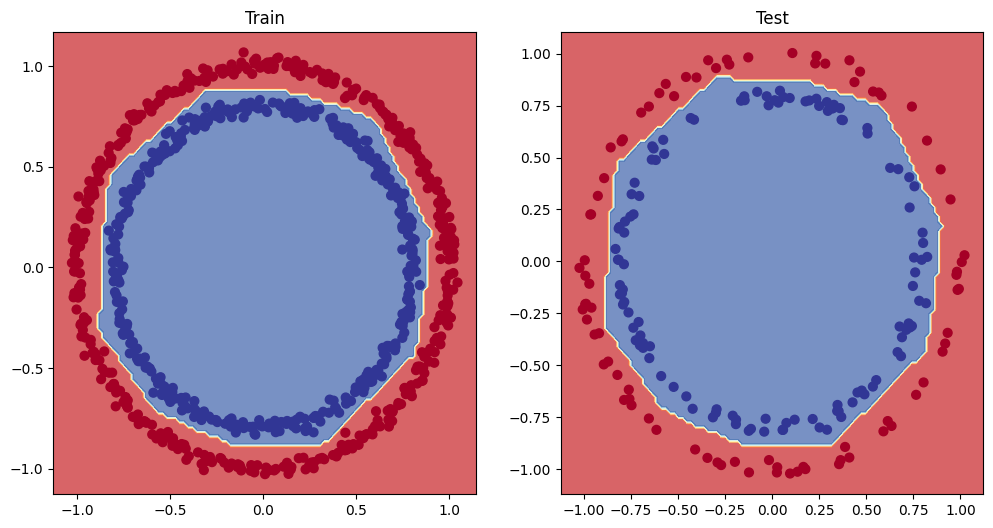

In [95]:
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model_3, x_train, y_train) # model_1 = no non-linearity
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model_3, x_test, y_test) # model_3 = has non-linearity